<a href="https://colab.research.google.com/github/MISAKITSUBASA/CSC413NeuralNetwork/blob/main/RNN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 413 2022 Tutorial 7: RNNs / LSTMs

**TA:** Ruian (Ian) Shi

This notebook provides an introduction to Recurrent Neural Networks.

Covered are:
* Implementations of RNNs and LSTMs
* Applications of RNNs
* Common challenges with RNNs and solutions
* Extensions of RNN architectures
* Examples of real world applications

Originally authored by Ian Shi.

## Notebook Utils
Run these code blocks before starting.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(413)
torch.manual_seed(413)

def plot_extrap(ds, tps):
    plt.figure(figsize=(10, 5))
    plt.plot(tps[0], ds[0]['obs'], label='Train Region')
    plt.plot(tps[1], ds[0]['pred'], label='Unseen Extrapolation Region')

    plt.axvline(tps[0][-1])
    plt.title("Extrapolation Task")
    plt.xlabel('t')
    plt.legend(loc='upper left')
    plt.show()

def lv(x, t, params):
    dx = params[0] * x[0] - params[1] * x[0] * x[1]
    dy = params[2] * x[0] * x[1] - params[3] * x[1]
    return dx, dy

def lv_solve(tp, initial, params):
    return odeint(lv, initial, tp, args=((params,)))

def generate_lv_dataset(n, tp, i_range, p_range, noise_var=0.25):
    dataset = []

    for _ in range(n):
        alpha = np.random.uniform(p_range[0][0], p_range[0][1])
        beta = np.random.uniform(p_range[1][0], p_range[1][1])
        delta = np.random.uniform(p_range[2][0], p_range[2][1])
        gamma = np.random.uniform(p_range[3][0], p_range[3][1])

        x = np.random.uniform(i_range[0][0], i_range[0][1])
        y = np.random.uniform(i_range[1][0], i_range[1][1])

        params = (alpha, beta, delta, gamma)
        traj = lv_solve(tp, (x, y), params)
        
        traj += np.random.randn(*traj.shape) * noise_var

        dataset.append(traj)
    
    return dataset

def visualize_lv(lv_tp, lv_data):
    fig, ax = plt.subplots(2, 2, figsize=(20, 6))

    for i in range(4):
        r = i // 2
        c = i % 2
        ax[r][c].plot(lv_tp, lv_data[i][:, 0], label="prey")
        ax[r][c].plot(lv_tp, lv_data[i][:, 1], label="predator")

        ax[r][c].scatter(lv_tp, lv_data[i][:, 0])
        ax[r][c].scatter(lv_tp, lv_data[i][:, 1])
        ax[r][c].legend(loc = "upper left")
    plt.show()

IRANGE = [[2, 4], [0.5, 1]]
PRANGE = [[0.35, 0.5], [0.15, 0.25], [0.05, 0.1], [0.25, 0.55]]


# Code Examples

## RNN Implementation


First, let's see how we can implement the RNN from scratch in PyTorch.  

Recall the equations (with biases omitted) corresponding to a single RNN update: 

$$\begin{align}h_t &= W_{ih} x_t +W_{hh} h_{t-1}\\
a_t &= tanh(h_t)\\
o_t &= softmax(W_{ho} a_t) \end{align}$$

The softmax convert outputs to probabilities, which can correspond to class labels / tokens, and is needed in most NLP tasks.  
We won't always need it though, so its set as an option. Linear layers can be used to represent all other operations.

In [ ]:
class OurRNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=None, softmax_out=False):
        super().__init__()
        if output_dim is None:
            output_dim = input_dim

        # Input processing
        self.in_net = nn.Linear(input_dim, hidden_dim)
        self.hid_net = nn.Linear(hidden_dim, hidden_dim)

        # Output processing
        self.activation = nn.Tanh()
        self.out_net = nn.Linear(hidden_dim, output_dim)

        # Apply softmax to get categorical output (example, word embeddings)
        # Since our later tasks output scalars, ignore.
        self.softmax = nn.Softmax()
        self.softmax_out = softmax_out

    def forward(self, x, prev_h):
        """
            X has shape B x 1 x D
            H has shape B x 1 x H

            (second dimension is flattened)
        """
        new_h = self.activation(self.in_net(x) + self.hid_net(prev_h))

        out = self.out_net(new_h)

        if self.softmax_out:
            out = self.softmax(out)

        return out, new_h

The RNN sequentially processes data using the same RNNCell. At each time step, the hidden state and outputs are updates as:

$$o_t, h_t = RNNCell(x_t, h_{t-1})$$

This process starts at $t=1$, where $h_0$ is randomly initialized, and continues for the length of the sequence.  
The variable $o_t$ is the output for that time step. A visual representation of this process is shown below:

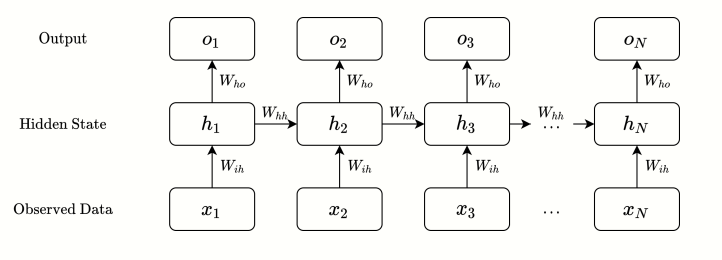

In [ ]:
class OurRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hid_dim = hidden_dim
        self.in_dim = input_dim

        self.rnn_cell = OurRNNCell(input_dim, hidden_dim)

    def forward(self, x):
        """
            X has shape B x T x D where
                B = Batch size
                T = Length of sequence
                D = Number of features
        """
        h = self.init_hidden(x.shape[0]).to(x.device)
        
        # Tracks output of whole sequence
        out_arr = []
    
        # Combine input at time t with previous hidden state
        for t in range(x.shape[1]):
            out, h = self.rnn_cell(x[:, t, :], h)
            out_arr.append(out)

        return out_arr, h

    def init_hidden(self, batch_size):
        """
        Hidden state must be assigned initial state. Usually non-informative,
        so set to zeros or random floats.
        """
        return torch.randn((batch_size, self.hid_dim))

The equivalent PyTorch implementation is available at: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html.  
For simplicity, we'll use the out-of-box PyTorch implementation. Several options, such as "n_layers" and "bidirectional", will be explored later.

## LSTM Implementation

The LSTM addresses the vanishing gradient problem through the inclusion of a cell state. This cell state can only be updated through several gates, meaning it can more easily preserve long-term information.

Each LSTM update is represented by the below equations (biases omitted):

$$ \begin{align}
f_t &= \sigma(W_{fi} x_t + W_{fh} h_{t-1}) \hspace{1em} [\text{Forget gate}] \\
i_t &= \sigma(W_{ii} x_t + W_{ih} h_{t-1}) \hspace{1em} [\text{Input gate}] \\
g_t &= \sigma(W_{gi} x_t + W_{gh} h_{t-1}) \hspace{1em} [\text{Update gate}] \\
o_t &= \sigma(W_{oi} x_t + W_{oh} h_{t-1}) \hspace{1em} [\text{Output gate}] \\
c_t &= c_t \odot f_t + i_t \odot g_t \\
h_t &= tanh(c_t) \odot o_t
\end{align}
$$

The key thing to remember is that the sigmoid activation squashes outputs between 0 and 1. Thus, when multiplied element-wise to the hidden or cell state, it represents how much of each dimension to keep / throw away.


A graphical representation, taken from https://colah.github.io/posts/2015-08-Understanding-LSTMs/, is shown below:

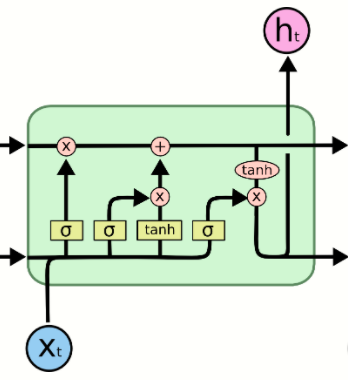

In [ ]:
class OurLSTMCell(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.forget_gate_i = nn.Linear(in_dim, hid_dim)
        self.forget_gat_h = nn.Linear(hid_dim, hid_dim)

        self.input_gate_i = nn.Linear(in_dim, hid_dim)
        self.input_gate_h = nn.Linear(hid_dim, hid_dim)

        self.update_gate_i = nn.Linear(in_dim, hid_dim)
        self.update_gate_h = nn.Linear(hid_dim, hid_dim)

        self.out_gate_i = nn.Linear(in_dim, hid_dim)
        self.out_gate_h = nn.Linear(hid_dim, hid_dim)

        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, hid_state, cell_state):
        # Forget unwanted cell states
        fg = self.sig(self.forget_gate_i(x) + self.forget_gate_h(hid_state))
        cell_state = cell_state * fg

        # Compute which cell states to update
        ig = self.sig(self.input_gate_i(x) + self.input_gate_h(hid_state))

        # Compute update values
        ug = self.tanh(self.update_gate_i(x) + self.update_gate_h(hid_state))

        # Perform cell state update
        update = ig * ug
        cell_state = cell_state + update

        # Compute output from cell state
        og = self.sig(self.out_gate_i(x) + self.out_gate(hid_state))

        hid_state = og * self.tanh(cell_state)

        return hid_state, cell_state

The LSTM is pretty much identical to the RNN in terms of its iteration.  
The only difference is that the cell state much be initialized in addition to the hidden state.

In [ ]:
class OurLSTM(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.LSTMCell = OurLSTMCell(in_dim, hid_dim, out_dim)

    def forward(self, x):
        """
            X has shape B x T x D where
                B = Batch size
                T = Length of sequence
                D = Number of features
        """
        h = self.init_hidden(x.shape[0]).to(x.device)
        c = self.init_cell(x.shape[0]).to(x.device)

        out_arr = []

        for t in range(x.shape[1]):
            h, c = self.LSTMCell(x[:, t, :], h, c)
            out_arr.append(h)
        
        return out_arr, h, c

    def init_hidden(self, batch_size):
        return torch.randn((batch_size, self.hid_dim))

    def init_cell(self, batch_size):
        return torch.randn((batch_size, self.hid_dim))

The equivalent PyTorch implementation is available at: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html. 

The GRU similarly contains several gates, but combines the input and forget gates, and merges the hidden and cell state. The main benefit of the GRU is memory efficiency, at about the same performance. In practice, due to the interchangeability of all three approaches, it's easy to apply them all and chose the one that works.

The GRU PyTorch implementation is available at: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

# Applications of RNNs
There are several broad tasks you may wish to perform on sequential data:


*   **Prediction**: Extrapolation / interpolate from an observed sequence.
*   **Classification**: Assign a class label to whole sequences.
*   **Translation**: Convert sequence in one space to another.

We will investigate how RNNs can be applied to each of these contexts. 


Aside: In previous years, tutorials were on NLP tasks, which are likely more relevant and interesting. However, training never converged during the tutorial time, which was quite unsatistfying. Since PA3 and the majority of CSC413 focuses on NLP, we'll mainly focus on non-NLP applications of RNNs. This year I've implemented some toy examples, but each section contains examples of real world applications where RNNs have been applied. 

## RNNs for Sequence Prediction & Forecasting


### Background

The RNN can be applied to predict the next observations in a sequence of data. 


Given an observed data sequence up to time $t$, denoted $x_{1:t}$, we can apply the RNN for prediction of the data values $x_{t:T}$ where $T>t$. Typically, values in this prediction region are unseen during training. This task is visually shown below:




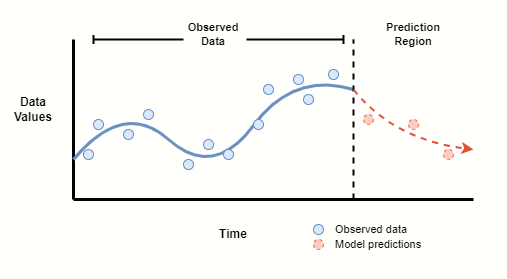

We apply the RNN in a manner known as autoregressive prediction for this task.
When input data is available, we update the RNN normally:

$$o_t, h_t = \text{RNNCell}(x_t, h_{t-1})$$

In the prediction region, where input data is unavailable, the RNN update is performed using the previous output:

$$o_t, h_t = \text{RNNCell}(o_{t-1}, h_{t-1})$$

This is visually shown below:

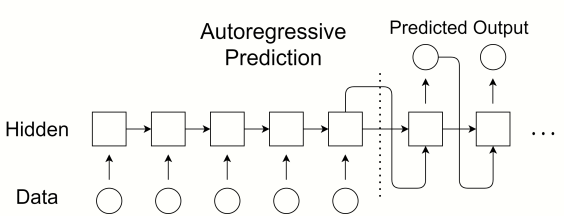

### Toy Data: Lotka-Voltera Model

We consider a simple sequence prediction example.

**Scenario:** Imagine you are an ecologist, tracking the populations of lynx and rabbits, which have a predator-prey relationship. You take measurements of both the predator and prey throughout the year, and discover a cyclical nature in their population levels. To avoid having to repeatedly trek into the wilderness, you decide to build a predictive model using an RNN. 

As as matter of fact, given observations from different eco-systems, could we forecast them all? Let's see how it might be possible!

(Aside: using an RNN is overkill here, this is just a demo.)




#### Background

This part describes how we generate the synthetic dataset. Skip if not interested.




We will use synthetic data to mimic actual observations. The Lotka-Voltera equations describe an overly simplified model of predator and prey in an eco-system over time. They are described by the following ODEs:

$$ \begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y \hspace{1em} [\text{prey}] \\
\frac{dy}{dt} &= \delta x y - \gamma y \hspace{1em} [\text{predator}]
\end{align}
$$

The parameters $\alpha, \beta, \delta, \gamma$ represent the rate of predation, reproduction, etc., and affect the shape and frequency of these curves. To generate synthetic data, we will randomly sample the parameters, and then solve for the equations.

#### Data Generation

Commonly, synthetic datasets are used to demonstrate the properties of a particular method, such as the RNN, before demonstrating their applicability on real data. We generate a synthetic dataset using the Lotka-Volterra model for predator-prey interaction, contained in the utility code. Random noise is added to increase the difficulty of the problem.

We treat the two populations as a single 2D input sequence. For different eco-systems, the frequency and amplitude of the trajectories vary.

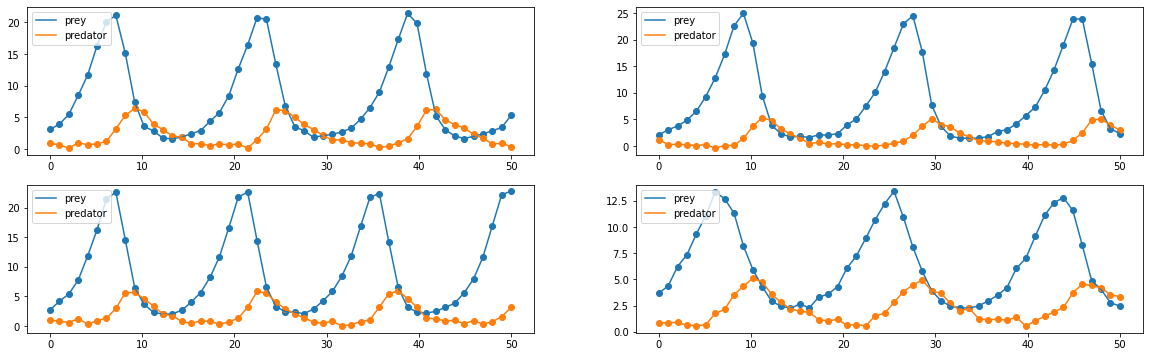

In [ ]:
lv_tp = np.linspace(0, 50, 50)
lv_data = generate_lv_dataset(1500, lv_tp, IRANGE, PRANGE, noise_var=0.25)

visualize_lv(lv_tp, lv_data)

To demonstrate the extrapolation ability of RNNs, we will divide the dataset into an encoding, validation prediction, and test prediction region:


*   Each trajectory is split at 50% and 75% of the datapoints. 
 * **Encoding region**: First 50% of data.
 * **Validation Prediction Region**: Data between 50% and 75%.
 * **Test Prediction Region**: Data after 75%, held out during training.

*   The trajectories in the dataset are split into training/validation/test sets.



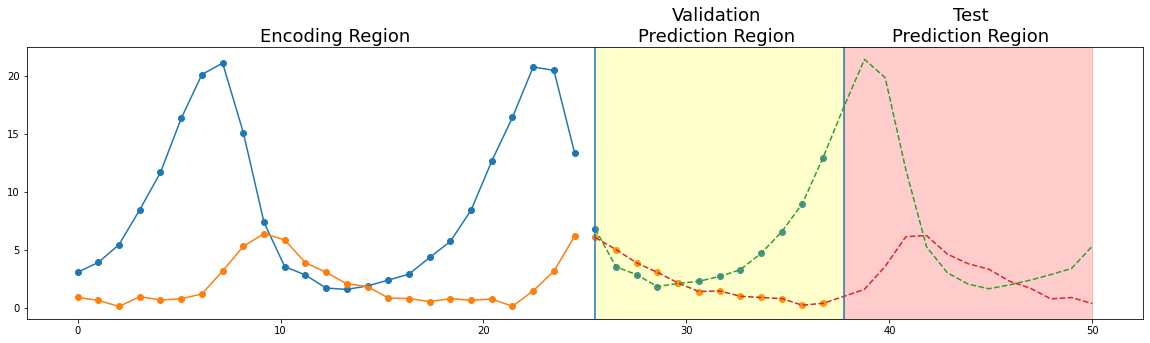

In [ ]:
plt.figure(figsize=(20, 5))

val_split = int(0.5*len(lv_tp))
test_split = int(0.75*len(lv_tp))

plt.plot(lv_tp[:val_split], lv_data[0][:val_split])
plt.plot(lv_tp[val_split:], lv_data[0][val_split:], ls='--')

plt.scatter(lv_tp[:test_split], lv_data[0][:test_split, 0])
plt.scatter(lv_tp[:test_split], lv_data[0][:test_split, 1])

plt.axvline(lv_tp[val_split])
plt.axvline(lv_tp[test_split])

plt.axvspan(lv_tp[val_split], lv_tp[test_split], color='yellow', alpha=0.2)
plt.axvspan(lv_tp[test_split], lv_tp[-1], color='red', alpha=0.2)

d_max = max(lv_data[0][:, 0]) + 1.5
plt.text(9, d_max, "Encoding Region", fontsize=18)
plt.text(31.5, d_max, "Validation\nPrediction Region", fontsize=18, ha='center')
plt.text(44, d_max, "Test\nPrediction Region", fontsize=18, ha='center')
plt.show()

Let's preprare the data for PyTorch. We'll also implement the split process here.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class LVData(Dataset):
    def __init__(self, data, tp):
        self.data = data
        self.tp = tp

    def __getitem__(self, idx):
        traj = self.data[idx]

        # Individual trajectories are split into train/val/test regions
        val_split = int(0.5 * len(traj))
        test_split = int(0.75 * len(traj))

        train_traj = traj[:val_split]
        val_traj = traj[val_split:test_split]
        test_traj = traj[test_split:]

        train_tp = self.tp[:val_split]
        val_tp = self.tp[val_split:test_split]
        test_tp = self.tp[test_split:]

        return train_traj, val_traj, test_traj, train_tp, val_tp, test_tp

    def __len__(self):
        return len(self.data)

lv_data_tensor = torch.Tensor(np.array(lv_data)).to(device)
lv_tp_tensor = torch.Tensor(np.array(lv_tp)).to(device)

# Splitting data into training / validation / test trajectories
lv_data_tv, lv_data_test = train_test_split(lv_data_tensor, test_size=0.1)
lv_data_train, lv_data_val = train_test_split(lv_data_tv, test_size=0.1)

# Create PyTorch data structures
lv_train_set = LVData(lv_data_train, lv_tp_tensor)
lv_val_set = LVData(lv_data_val, lv_tp_tensor)
lv_test_set = LVData(lv_data_test, lv_tp_tensor)

lv_train_loader = DataLoader(lv_train_set, batch_size=32, shuffle=True)
lv_val_loader = DataLoader(lv_val_set, batch_size=256, shuffle=False)
lv_test_loader = DataLoader(lv_test_set, batch_size=256, shuffle=False)

#### Model

For simplicity, we'll use the standard PyTorch LSTM to power our predictions.  
We need to implement the autoregressive prediction though, and will use a wrapper model to do so.

In [ ]:
class LSTMPredictor(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim=None):
        super().__init__()
        if out_dim is None:
            out_dim = in_dim

        # Use to map hidden to output space
        self.out_net = nn.Linear(hid_dim, out_dim)

        self.lstm = nn.LSTM(in_dim, hid_dim, batch_first=True)

    def forward(self, x):
        # The LSTM returns the output for each timesteps in a (B x T x H) array
        # The other output is a tuple of the final hidden and cell states.
        # For the forward function, we will just pass the values through.
        out, state = self.lstm(x)
        return out, state

    def predict(self, x, K):
        """ 
        This method implements autoregressive prediction.

        K: the number of steps we want to predict.     
        """
        # First, we want to get the hidden representation of observed data
        out, state = self.lstm(x)

        predictions = []

        """
        To predict unseen data, we use the last LSTM output as the input for 
        the next timestep. Recall, `out` is (B x T x H), meaning we need to
        use a linear layer to map to the output dimension. This must be 
        repeated for all outputs to get our predictions.
        """
        last_output = out[:, -1:, :]
        next_input = self.out_net(last_output)
        for _ in range(K):
            # We want to persist the hidden/cell states for the next LSTM cell
            raw_out, state = self.lstm(next_input, state)

            pred = self.out_net(raw_out)

            predictions.append(pred)
            next_input = pred

        return torch.cat(predictions, axis=1)


#### Training
Now we train on the data. We want to minimize the mean squared error (MSE) between predicted and actual populations.  
Also note that adaptive optimizers, like Adam, are believed to work better on recurrent architectures.

Epoch 0: Train Loss 22.317495019812334, Val Loss 20.486251831054688
Epoch 10: Train Loss 3.326574771027816, Val Loss 2.8611369132995605
Epoch 20: Train Loss 1.0462459168936078, Val Loss 0.9404670000076294
Epoch 30: Train Loss 0.5454302579164505, Val Loss 0.5063781142234802
Epoch 40: Train Loss 0.37089532692181437, Val Loss 0.32455384731292725


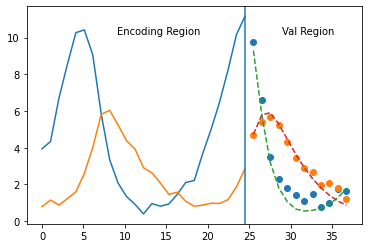

In [ ]:
from torch.optim import Adam

lstm = LSTMPredictor(2, 100).to(device)
opt = Adam(lstm.parameters(), lr=3e-4)

# Main training loop
for epoch in range(41):
    t_loss_sum = 0
    for batch in lv_train_loader:
        opt.zero_grad()
        train_region, val_region, _, train_tp, val_tp, _ = batch

        # Fit model on training region, predict in validation region
        n_steps_pred = len(val_region[0])
        pred = lstm.predict(train_region, n_steps_pred)

        # Take a squared loss between predicted vs actual
        train_loss = nn.MSELoss()(pred, val_region)

        train_loss.backward()
        opt.step()

        t_loss_sum += train_loss.item()

    # Evaluate validation loss at specific intervals
    if epoch % 10 == 0:
        # Make sure to not compute gradients when computing validation loss
        with torch.no_grad():
            v_loss_sum = 0
            for v_batch in lv_val_loader:
                train_region, val_region, _, train_tp, val_tp, _ = v_batch

                n_steps_pred = len(val_region[0])
                pred = lstm.predict(train_region, n_steps_pred)

                val_loss = nn.MSELoss()(pred, val_region)
                v_loss_sum += val_loss.item()

        avg_t_loss = t_loss_sum / len(lv_train_loader)
        avg_v_loss = v_loss_sum / len(lv_val_loader)
        out_msg = "Epoch {}: Train Loss {}, Val Loss {}"
        print(out_msg.format(epoch, avg_t_loss, avg_v_loss))

with torch.no_grad():
    plt.plot(train_tp[0], train_region[0])
    plt.scatter(val_tp[0], val_region[0][:, 0])
    plt.scatter(val_tp[0], val_region[0][:, 1])
    plt.plot(val_tp[0], pred[0], ls='--')
    plt.axvline(train_tp[0, -1])
    d_max = max(torch.max(val_region[0]), torch.max(train_region[0]))
    d_max = max(d_max, torch.max(pred[0]))

    plt.text(9, d_max-1, "Encoding Region")
    plt.text(29, d_max-1, "Val Region")
    plt.show()

Nice! It looks like our RNN can perform extrapolation quite well. We confirm the generalization by evaluating loss on both the test region, and the trajectories in the test set.

You can make arbitrarily long autoregressive predictions. To get predictions in the test region, we just continue the autoregressive process. However, predictions typically become less accurate as the length of the prediction increases.

#### Results

Test Loss: 3.621645927429199


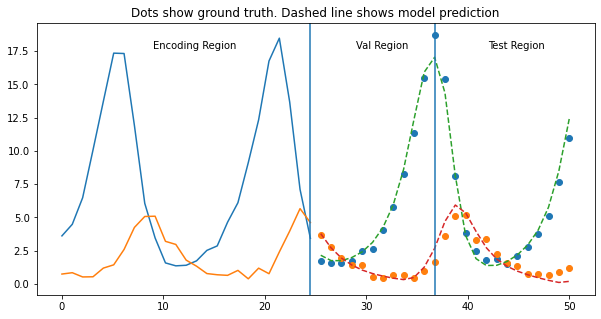

In [ ]:
test_loss_sum = 0

for batch in lv_test_loader:
    opt.zero_grad()
    train_region, val_region, test_region, train_tp, val_tp, test_tp = batch

    val_len = len(val_region[0])
    test_len = len(test_region[0])

    # Can set arbitrarily long sequence
    n_steps_pred = val_len + test_len
    pred = lstm.predict(train_region, n_steps_pred)

    val_pred = pred[:, :val_len]
    test_pred = pred[:, val_len:val_len+test_len]
    test_loss = nn.MSELoss()(test_pred, test_region)

    test_loss_sum += test_loss

print("Test Loss: {}".format(test_loss_sum / len(lv_test_loader)))

# Plotting result
with torch.no_grad():
    ground_truth = torch.cat([val_region[0], test_region[0]], axis=0)
    cat_tp = torch.cat([val_tp[0], test_tp[0]])

    cat_pred = torch.cat([val_pred[0], test_pred[0]])

    plt.figure(figsize=(10, 5))
    plt.plot(train_tp[0], train_region[0])
    plt.scatter(cat_tp, ground_truth[:, 0])
    plt.scatter(cat_tp, ground_truth[:, 1])

    plt.plot(cat_tp, cat_pred, ls='--')
    plt.axvline(train_tp[0][-1])
    plt.axvline(val_tp[0][-1])

    d_max = max(torch.max(cat_pred), torch.max(ground_truth))
    plt.text(9, d_max-1, "Encoding Region")
    plt.text(29, d_max-1, "Val Region")
    plt.text(42, d_max-1, "Test Region")
    plt.title("Dots show ground truth. Dashed line shows model prediction")
    plt.show()

### Scheduled Sampling

While our toy problem is quite simple, autoregressive prediction can often be difficult to train. In particular, reusing outputs as inputs can cause errors to accumulate as the length of prediction increases. 

One common enhancement is to apply Scheduled Sampling (https://arxiv.org/pdf/1506.03099.pdf). During training, we randomly allow the model to use the true input, thus correcting any accumulated errors. In practice, this allows faster convergence and better performance.  


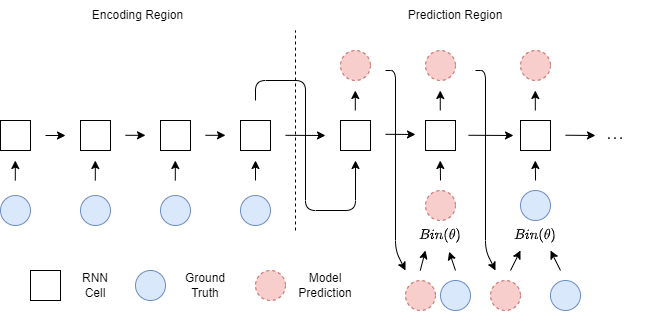

A simplified version is shown below. Typically, the probability of using ground truth data is lowered as training is progressed, forcing the model to learn on its own. **Always make sure to disable replacement  when evaluating model performance**.

In [ ]:
class LSTMScheduledSampler(LSTMPredictor):
    def __init__(self, in_dim, hid_dim, out_dim=None):
        super().__init__(in_dim, hid_dim, out_dim=None)

    def predict(self, x, ground_truth, K, threshold):
        """ 
        Autoregressive prediction with scheduled sampling.

        One cavet is that you need to have data for the prediction region.
        (Which you should, for validation purposes)

        Threshold is the probability we replace the model output with ground 
        truth. Set to 0 when evaluating.
        """
        out, state = self.lstm(x)

        predictions = []

        last_output = out[:, -1:, :]
        next_input = self.out_net(last_output)

        for i in range(K):
            # Randomly replace model output with ground truth
            if np.random.uniform(0, 1) < threshold:
                next_input = ground_truth[:, i, :].unsqueeze(1)

            raw_out, state = self.lstm(next_input, state)

            pred = self.out_net(raw_out)

            predictions.append(pred)
            next_input = pred

        return torch.cat(predictions, axis=1)


### Missing / Irregularly Sampled Data

One problem you may encounter when dealing with sequential data in the wild is that of **irregular sampling**. This is when the time that elapses between observations is not equal, i.e., your data is not evenly spaced. Alternatively, you can view the problem as **missing** certain observations. While this isn't an issue in NLP, other forms of sequential data often feature this problem.

An example of irregularly sampled data is shown below.

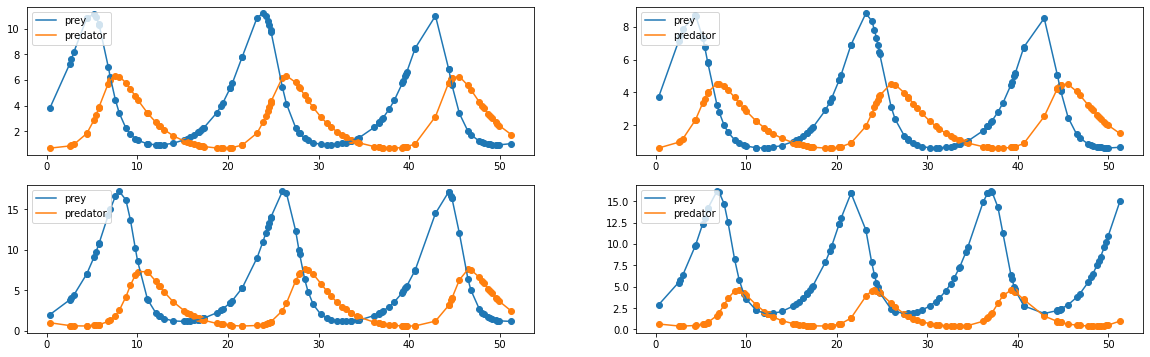

In [ ]:
ir_lv_tp = np.linspace(0, 50, 100)

# Add noise to time to simulate irregular sampling
ir_lv_tp = np.sort(ir_lv_tp + np.random.rand(*ir_lv_tp.shape)*3)
ir_lv_data = generate_lv_dataset(10, ir_lv_tp, IRANGE, PRANGE, noise_var=0)

visualize_lv(ir_lv_tp, ir_lv_data)

Irregularly sampled data appears frequently in real datasets. For example, in a medical setting, measurements of patient vitals may increase in frequency when status deteriorates, and vice versa. 

Several strategies exist to handle irregularly sampled data:


*   **Interpolation** of input data on regular interval (https://docs.scipy.org/doc/scipy/reference/interpolate.html)
*   Incorporating **time delta** between observations as input feature into RNN
*   Sophisticated methods, for example **GRU-D** (https://www.nature.com/articles/s41598-018-24271-9), which learns a decay function between observations. 



### Real World Applications

The LSTM is ubiquitous in sequence prediction, and was in-fact the dominant method until 2017. For NLP sequence prediction tasks, the Transformer / Attention architecture has made the LSTM somewhat obsolete, and you will learn about them in the upcoming lecture and PA3.

For many non-NLP domains, the LSTM is still the go-to deep neural method. Some examples include:
 
 * Epidemiology, COVID caseload forecasting:  
 (https://www.sciencedirect.com/science/article/pii/S0960077920302642)
 * Financial time series forecasting:  
 (https://doi.org/10.1016/j.physa.2018.11.061), (https://ieeexplore.ieee.org/document/7364089)
 * Enviromental forecasting:  
 (https://www.mdpi.com/2073-4441/11/7/1387), (https://doi.org/10.1016/j.apr.2020.05.015)

## RNNs for Sequence Classification

Sequence classification is another important task RNNs can be applied to.  
In this task, we are given an observed sequence, and asked to assign a class label to the sequence.

When applying RNNs for this task, we first encode the observed data sequence into a hidden representation. Typically, the last hidden state is used as the representation of the entire sequence. Another neural network is used to map from the last hidden state to class labels. Alternatively, you could also use other machine learning methods. The process is visualized below:

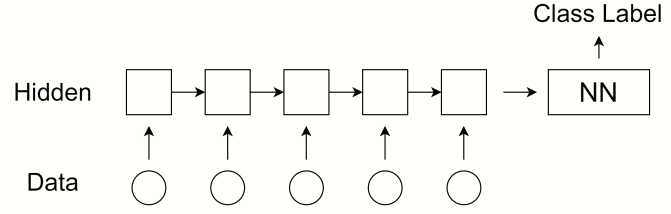

### Toy Data: Handwriting Classification

We use the UCI Character Trajectories dataset as our toy example.

The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Character+Trajectories.  
As a side note, the UCI repository contains many benchmark datasets, which can be a useful way to evaluate your research.

First, lets load the data!

In [ ]:
import urllib.request
from scipy.io import loadmat

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/character-trajectories/mixoutALL_shifted.mat"
fpath, _ =  urllib.request.urlretrieve(url, 'chartraj.mat')

ct_raw_data = loadmat(fpath)

#### Data Exploration / Processing

The UCI Character Trajectories data set contains the trajectories of an electronic pen as it writes one of 20 alphabetical letters. There are ~150 trajectories for each letter, and 2585 characters in total.

Each trajectory is 3 dimensional, corresponding to the x-position, y-position, and pen-tip force while writing the character. Each trajectory is evenly sampled, and has approximately 100 observations.


We first load the labels, and establish a character-index (and reverse) mapping.

In [ ]:
chars = ct_raw_data['consts'][0][0][3][0]
cid_map = {c[0]:i for i, c in enumerate(chars)}
rcid_map = {i:c[0] for i, c in enumerate(chars)}

ct_labels = ct_raw_data['consts'][0][0][4][0] - 1

print("Dataset contains letters: [{}]".format("".join([c[0] for c in chars])))
print("Dataset contains {} datapoints.".format(len(ct_labels)))

count = {rcid_map[i]:0 for i in range(20)}

for l in ct_labels:
    count[rcid_map[l]] += 1
print("Individual character counts are: {}".format(count))

Dataset contains letters: [abcdeghlmnopqrsuvwyz]
Dataset contains 2858 datapoints.
Individual character counts are: {'a': 171, 'b': 141, 'c': 142, 'd': 157, 'e': 186, 'g': 138, 'h': 127, 'l': 174, 'm': 125, 'n': 130, 'o': 141, 'p': 131, 'q': 124, 'r': 119, 's': 133, 'u': 131, 'v': 155, 'w': 125, 'y': 137, 'z': 171}


Next, we load the data, remove leading/trailing zeros, and visualize.  
We'll subsample the trajectories for faster training.

In [ ]:
ct_data = ct_raw_data['mixout'][0]
ct_data = [d.T for d in ct_data]
# Strip zeros
ct_data = [d[~np.all(d==0, axis=1), :] for d in ct_data]
# Take only one third of dataset
ct_data = [d[::3] for d in ct_data]

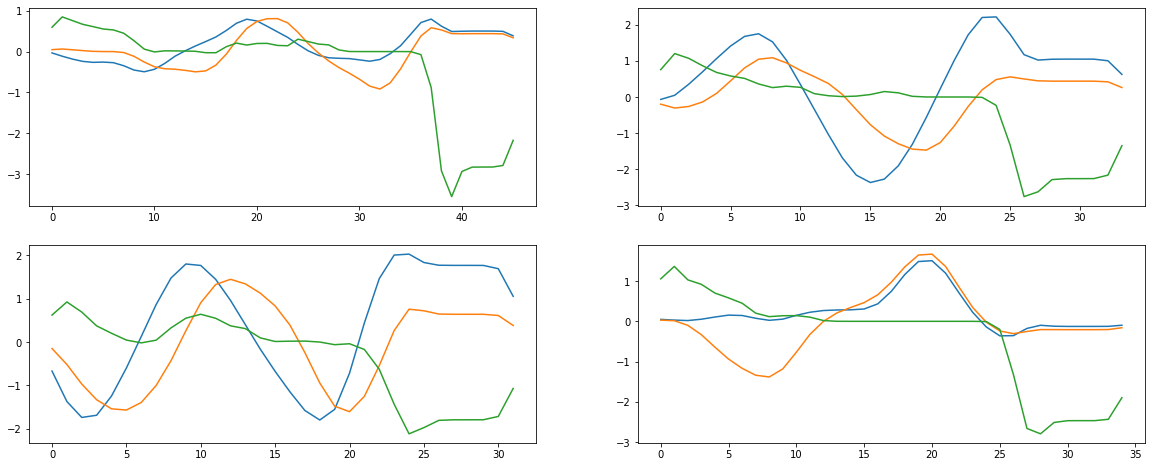

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(20, 8))
ax[0][0].plot(ct_data[0])
ax[0][1].plot(ct_data[400])
ax[1][0].plot(ct_data[800])
ax[1][1].plot(ct_data[1200])
plt.show()

#### Trajectories of Uneven Length
But wait, a problem has arised... The trajectories are different length! How can we efficiently process them in a mini-batch, when tensors must be of a fixed length? To address this problem, PyTorch has a built in method to efficiently handle data with different lengths. The documentation is shown below:

*   https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html
*   https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html
*   https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html

These functions first pad the uneven sequences with zeros at the end, such that they are of equal length. At train and test time, we can use PyTorch to convert these sequences into a data structure for efficient computation, and then revert it back.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split

class CharTrajDS(Dataset):
    def __init__(self, data, labels):
        self.labels = labels

        # Use PyTorch built-in to pad zeros.
        t_data = [torch.Tensor(d) for d in data]
        self.data = pad_sequence(t_data, batch_first=True).to(device)

        # Need to persist original lengths
        self.lens = [len(d) for d in data]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.lens[idx]
    def __len__(self):
        return len(self.data)

ct_tv_data, ct_test_data, ct_tv_lab, ct_test_lab = train_test_split(ct_data, ct_labels, test_size=0.1)
ct_train_data, ct_val_data, ct_train_lab, ct_val_lab = train_test_split(ct_tv_data, ct_tv_lab, test_size=0.1)

ct_train_ds = CharTrajDS(ct_train_data, ct_train_lab)
ct_val_ds = CharTrajDS(ct_val_data, ct_val_lab)
ct_test_ds = CharTrajDS(ct_test_data, ct_test_lab)

ct_train_loader = DataLoader(ct_train_ds, batch_size=64, shuffle=True)
ct_val_loader = DataLoader(ct_val_ds, batch_size=256, shuffle=False)
ct_test_loader = DataLoader(ct_test_ds, batch_size=256, shuffle=False)

#### Model 

Pretty standard. We use a simple 1 layer neural network classifier on the last hidden output. The only tricky part is that we must retrieve the last non-padded output from the array of outputs.

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMClassifier(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, lstm_model=None):
        super().__init__()

        if lstm_model is None:
            self.lstm = nn.LSTM(in_dim, hid_dim)
        else:
            self.lstm = lstm_model

        self.classifier = nn.Sequential(nn.Linear(hid_dim, out_dim))

    def forward(self, x, lens):
        # Pack the input for processing
        packed_in = pack_padded_sequence(x, lens, batch_first=True, 
                                         enforce_sorted=False)
        out, (h, c) = self.lstm(packed_in)
        
        # Convert back from PyTorch data structure
        out, last_ind = pad_packed_sequence(out, batch_first=True)
        
        # We must reselect the last non-padded output
        class_in = out[torch.arange(out.shape[0]), last_ind-1, :]

        pred = self.classifier(class_in)
        return pred

#### Training

As standard, we use a cross-entropy loss when performing multiclass classification.

In [ ]:
def train_loop(model, opt, t_loader, v_loader, epochs):
    for epoch in range(epochs):
        t_loss_sum = 0
        v_loss_sum = 0
        for batch in t_loader:
            opt.zero_grad()

            data, label, lens = batch
            pred = model(data, lens)

            loss = nn.CrossEntropyLoss()(pred, label)
            loss.backward()
            opt.step()
            t_loss_sum += loss.item()
        
        with torch.no_grad():
            for batch in v_loader:
                data, label, lens = batch
                pred = model(data, lens)

                loss = nn.CrossEntropyLoss()(pred, label)
                v_loss_sum += loss.item()
        
        if epoch % 5 == 0:
            out = "Epoch {}: Train Loss {}, Val Loss {}"
            avg_t_loss = t_loss_sum / len(t_loader)
            avg_v_loss = v_loss_sum / len(v_loader)
            print(out.format(epoch, avg_t_loss, avg_v_loss))

In [ ]:
from torch.optim import Adam

model = LSTMClassifier(3, 50, 20).to(device)
opt = Adam(model.parameters(), lr=1e-3)

train_loop(model, opt, ct_train_loader, ct_val_loader, 21)

Epoch 0: Train Loss 2.957561782888464, Val Loss 2.7994810342788696
Epoch 5: Train Loss 0.9530275351292378, Val Loss 0.7569835186004639
Epoch 10: Train Loss 0.4503691494464874, Val Loss 0.27457088977098465
Epoch 15: Train Loss 0.25033595392832886, Val Loss 0.15031218901276588
Epoch 20: Train Loss 0.17828103416674845, Val Loss 0.11894179042428732


#### Results

In [ ]:
from sklearn.metrics import f1_score

def evaluate_model(model, t_loader):
    with torch.no_grad():
        test_loss_sum = 0
        test_correct = 0
        all_pred = []
        all_lab = []
        for batch in t_loader:
            data, label, lens = batch
            
            pred = model(data, lens)

            loss = nn.CrossEntropyLoss()(pred, label)
            test_loss_sum += loss.item()

            pred_lab = pred.argmax(1)
            correct = sum(pred_lab == label)
            test_correct += correct

            all_pred += list(pred_lab)
            all_lab += list(label)
        
        print("Test Loss: {}".format(test_loss_sum / len(t_loader)))
        print("Test Acc: {}".format(test_correct / len(ct_test_data)))
        f1 = f1_score(all_lab, all_pred, average='macro')
        print("F1 Score: {}".format(f1))

In [ ]:
evaluate_model(model, ct_test_loader)

Test Loss: 0.3226592540740967
Test Acc: 0.9195803999900818
F1 Score: 0.9079146989812212


### Gradient Clipping

As you may have seen in the lecture notes (https://csc413-uoft.github.io/2021/assets/readings/L07b.pdf), gradient clipping is a method to prevent exploding gradients. This is done by capping the magnitude of the gradient. While this means your gradient becomes biased, it is sometimes worth the tradeoff of an exploding gradient. 

PyTorch provides a built-in method to do this:  
https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html

An example code snippet is provided below.

In [ ]:
# 1. Obtain model predictions as usual
batch = next(iter(ct_train_loader))
data, label, lens = batch
pred = model(data, lens)

# 2: Compute gradients
loss = nn.CrossEntropyLoss()(pred, label)
loss.backward()

# We can inspect some weights to check the gradients
print("Unclipped Gradients:\n", model.classifier[0].weight.grad[0])

# 3: Perform gradient clipping (set norm to be small for demonstration)
torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

# The gradients are now clipped
print("Clipped Gradients:\n",model.classifier[0].weight.grad[0])

# 4: Update weights as usual
#opt.step()

Unclipped Gradients:
 tensor([ 0.0053,  0.0023, -0.0028, -0.0017,  0.0035, -0.0018, -0.0025, -0.0067,
        -0.0064,  0.0025, -0.0027, -0.0040, -0.0027, -0.0019,  0.0057,  0.0014,
         0.0032, -0.0001,  0.0016, -0.0022, -0.0011, -0.0035,  0.0028,  0.0011,
        -0.0065,  0.0007, -0.0005, -0.0013,  0.0016, -0.0037, -0.0016,  0.0015,
         0.0033, -0.0013, -0.0003, -0.0006,  0.0028,  0.0029, -0.0003,  0.0064,
        -0.0028, -0.0006,  0.0018,  0.0044,  0.0018, -0.0054, -0.0016, -0.0018,
        -0.0015,  0.0017])
Clipped Gradients:
 tensor([ 1.6998e-04,  7.2170e-05, -8.9307e-05, -5.3640e-05,  1.1142e-04,
        -5.7094e-05, -7.8913e-05, -2.1524e-04, -2.0608e-04,  7.9146e-05,
        -8.5382e-05, -1.2937e-04, -8.6120e-05, -6.2365e-05,  1.8242e-04,
         4.4227e-05,  1.0153e-04, -4.7061e-06,  5.2048e-05, -7.0667e-05,
        -3.4231e-05, -1.1120e-04,  8.9635e-05,  3.4033e-05, -2.0938e-04,
         2.2007e-05, -1.5517e-05, -4.0708e-05,  5.1722e-05, -1.1769e-04,
        -5.24

### Stacked RNNs


One way to increase the capacity/representational power of an RNN is by stacking layers, in an architecture known as a Stacked RNN. 

In this configuration, the outputs from the first layer of the RNN is used as input for a second layer of RNN. This continues for however many layers are specified. This is visualized below. Just like CNN, it is believed that deeper layers of the RNN will learn higher level representations of sequential features.


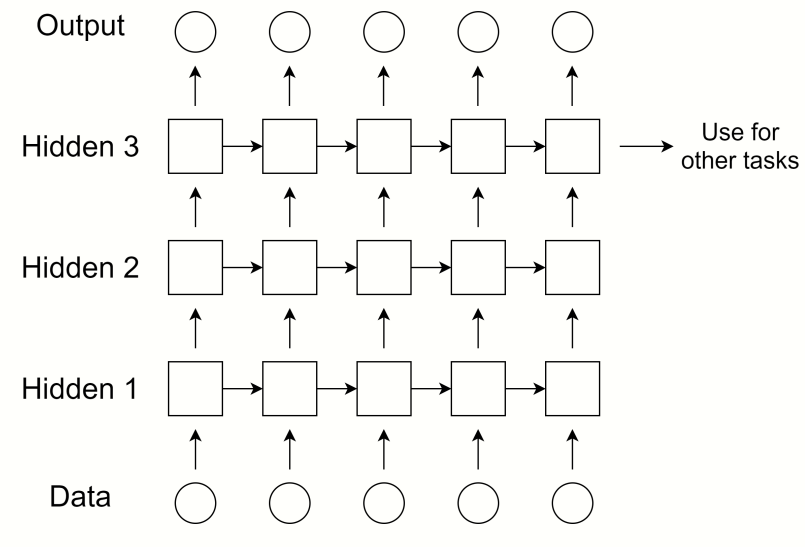


PyTorch provides a very simple option to increase the number of layers in its default RNN/LSTM implementations.

In [ ]:
st_lstm = nn.LSTM(3, 35, num_layers=2)
st_lstm_classifier = LSTMClassifier(3, 35, 20, lstm_model=st_lstm).to(device)

st_opt = Adam(st_lstm_classifier.parameters(), lr=1e-3)

train_loop(st_lstm_classifier, st_opt, ct_train_loader, ct_val_loader, 21)
evaluate_model(st_lstm_classifier, ct_test_loader)

Epoch 0: Train Loss 2.985769200969387, Val Loss 2.9075199365615845
Epoch 5: Train Loss 0.9549692160374409, Val Loss 0.773076593875885
Epoch 10: Train Loss 0.2996649407857173, Val Loss 0.22395890951156616
Epoch 15: Train Loss 0.14644804919088208, Val Loss 0.09769528731703758
Epoch 20: Train Loss 0.09154126833419542, Val Loss 0.05889343470335007
Test Loss: 0.15962520614266396
Test Acc: 0.9860140085220337
F1 Score: 0.9841151742993848


It looks like the test performance increases a little bit (depending on the random seed). As usual, you should always trade off model complexity and the potential for overfitting. 

### RNN Dropout


Dropout is commonly used to prevent overfitting and regularize neural networks. Could we do this for RNNs too? 

For Stacked RNNs, dropout is available out-of-the-box in PyTorch between RNN layers, where each RNN output has a specified probability of being dropped out. As always, remember to switch the model to eval mode when evaluating test performance, when applying dropout.

In [ ]:
do_lstm = nn.LSTM(3, 35, num_layers=2, dropout=0.5)
do_lstm_classifier = LSTMClassifier(3, 35, 20, lstm_model=do_lstm).to(device)

st_opt = Adam(do_lstm_classifier.parameters(), lr=1e-3)

train_loop(do_lstm_classifier, st_opt, ct_train_loader, ct_val_loader, 21)
do_lstm_classifier.eval()
evaluate_model(do_lstm_classifier, ct_test_loader)

Epoch 0: Train Loss 2.9878439001134924, Val Loss 2.966567039489746
Epoch 5: Train Loss 1.35171352528237, Val Loss 1.273581624031067
Epoch 10: Train Loss 0.610712515341269, Val Loss 0.4882289469242096
Epoch 15: Train Loss 0.3239069496457641, Val Loss 0.2535933405160904
Epoch 20: Train Loss 0.2530553610743703, Val Loss 0.1803867407143116
Test Loss: 0.2938692569732666
Test Acc: 0.9510489702224731
F1 Score: 0.9510413701641323


### Bi-Directional RNNs

Bi-directional RNNs are another innovation for RNNs, and are particularly useful for NLP tasks. Consider the following task where you want to interpolate a sentence (fill in the blank).

**"The _____ is a flightless bird that lives in Antarctica"**


If we applied the RNN normally, from left to right, the model would not have the context to accurately predict the blank.  
Working from right to left however, enough context is available.

The Bi-Directional RNN simply runs the two separate RNNs from either direction of the sequence. Then, the output from each RNN direction is concatenated prior to output. This is shown visually below, again from Chris Olah's blog: http://colah.github.io/posts/2015-09-NN-Types-FP/




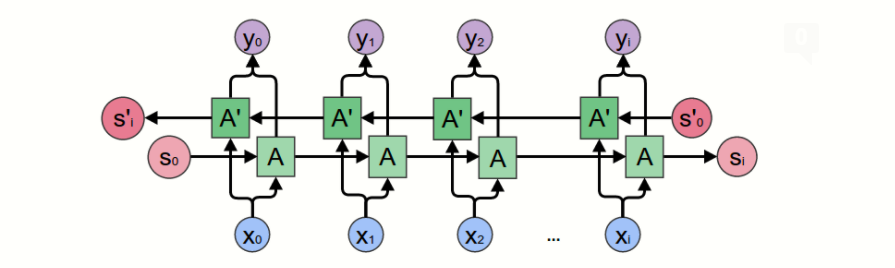

PyTorch again allows easy application of the Bi-Directional RNN as a built-in option: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html.


We demonstrate a bi-directional LSTM below, but its unlikely to perform better since no backwards context is required for our task.

In [ ]:
bi_lstm = nn.LSTM(3, 35, bidirectional=True)
bi_lstm_classifier = LSTMClassifier(3, 70, 20, lstm_model=bi_lstm).to(device)

bi_opt = Adam(bi_lstm_classifier.parameters(), lr=1e-3)

train_loop(bi_lstm_classifier, bi_opt, ct_train_loader, ct_val_loader, 21)
evaluate_model(bi_lstm_classifier, ct_test_loader)

Epoch 0: Train Loss 2.9610093606484904, Val Loss 2.8003278970718384
Epoch 5: Train Loss 1.573724076554582, Val Loss 1.264131784439087
Epoch 10: Train Loss 0.8212869763374329, Val Loss 0.5501769334077835
Epoch 15: Train Loss 0.5236696979484042, Val Loss 0.330549493432045
Epoch 20: Train Loss 0.3438040497335228, Val Loss 0.2192244715988636
Test Loss: 0.3458893299102783
Test Acc: 0.9615384340286255
F1 Score: 0.9568141219943875


### Real World Applications

Again many real-world problems can be framed as a sequence classification problem.

For example, in the domains of: 

*   NLP: 
 *  Sentiment analysis: Classifying language as positive/negative towards a subject (https://www.tensorflow.org/text/tutorials/text_classification_rnn).
 *  Hate speech detection: Classifying language as hate speech  
 (https://ieeexplore.ieee.org/document/8712104)
* Spoken Language Processing:
 * Speaker Identification: Identifying different speakers in audio data.  
 (https://arxiv.org/abs/1710.10468)
* Health:
 * Human Activity Recognition from accelerometers:  
   (https://arxiv.org/pdf/1611.03607.pdf)
 * Sleep stage classification:  
 (https://www.frontiersin.org/articles/10.3389/fncom.2018.00085/full)
 * Prediction of ICU Mortality:  
 (https://www.ncbi.nlm.nih.gov/labs/pmc/articles/PMC6934094/)

*   Computational Biology:
 *  Classification of DNA sequences  
 (https://www.nature.com/articles/s41598-018-33321-1)



## RNNs for Translation: Seq2Seq

RNNs can be applied to the NLP task of language translation in a manner very similar to autoregressive prediction.  
Instead of outputting real values as before, the RNN decoder can simply be made to output word vectors. Thus, you convert one sequence to another, which is why this task is sometimes known as Seq2Seq.

A code example is shown in the tutorial below:

See: https://colab.research.google.com/github/csc413-uoft/2021/blob/master/assets/tutorials/tut07_rnn.ipynb